# Spinful ferions within s-d model

Here we use "hardware friendly" problem agnostic anzatz for the problem.

In [34]:
#!pip install qiskit_ibm_runtime

In [27]:
#Qiskit modules
import qiskit
from qiskit import QuantumRegister as Q_R
from qiskit import ClassicalRegister as C_R
from qiskit_aer import Aer
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit.primitives import StatevectorSampler, StatevectorEstimator
from qiskit.quantum_info import SparsePauliOp

#math modules
import math
# SciPy minimizer routine
from scipy.optimize import minimize


import time

## Here are the functions performing Jordan-Wigner transformation for fermionc Pauli operators

Important notes:

1) This is spin-depenedent version, so each node has spin-coordinate and is described by 2 qubits.

   Spin-up state for node i is described by qubit i.

   Spin-down state for node i is described by qubit i + N, where N is the nodes number.



In [6]:
nodes_number = 2

def sigma_x(node, nodes_number):
    if node > nodes_number - 1:
        print('Error: node index (''node'') cannot be higher than the total number of nodes')
        return -1
    interaction_string_1 = ''
    #term one
    if node > 0:
        for i in range(0, node):
            interaction_string_1 = interaction_string_1 + 'I'
    interaction_string_1 = interaction_string_1 + 'X'
    for i in range(node + 1, node + nodes_number):
        interaction_string_1 = interaction_string_1 + 'Z'
    interaction_string_1 = interaction_string_1 + 'Y'
    for i in range(node + nodes_number + 1, nodes_number * 2):
        interaction_string_1 = interaction_string_1 + 'I'
    #term two
    interaction_string_2 = ''
    if node > 0:
        for i in range(0, node):
            interaction_string_2 = interaction_string_2 + 'I'
    interaction_string_2 = interaction_string_2 + 'Y'
    for i in range(node + 1, node + nodes_number):
        interaction_string_2 = interaction_string_2 + 'Z'
    interaction_string_2 = interaction_string_2 + 'X'
    for i in range(node + nodes_number + 1, nodes_number * 2):
        interaction_string_2 = interaction_string_2 + 'I'
    bits = range(nodes_number * 2)
    interactions = [(interaction_string_1, bits, 1j/2)]
    interactions.append((interaction_string_2, bits, 1j/2))
    hamiltonian = SparsePauliOp.from_sparse_list(interactions, num_qubits = 2 * nodes_number)
    return hamiltonian

def sigma_y(node, nodes_number):
    if node > nodes_number - 1:
        print('Error: node index (''node'') cannot be higher than the total number of nodes')
        return -1
    interaction_string_1 = ''
    #term one
    if node > 0:
        for i in range(0, node):
            interaction_string_1 = interaction_string_1 + 'I'
    interaction_string_1 = interaction_string_1 + 'X'
    for i in range(node + 1, node + nodes_number):
        interaction_string_1 = interaction_string_1 + 'Z'
    interaction_string_1 = interaction_string_1 + 'X'
    for i in range(node + nodes_number + 1, nodes_number * 2):
        interaction_string_1 = interaction_string_1 + 'I'
    #term two
    interaction_string_2 = ''
    if node > 0:
        for i in range(0, node):
            interaction_string_2 = interaction_string_2 + 'I'
    interaction_string_2 = interaction_string_2 + 'Y'
    for i in range(node + 1, node + nodes_number):
        interaction_string_2 = interaction_string_2 + 'Z'
    interaction_string_2 = interaction_string_2 + 'Y'
    for i in range(node + nodes_number + 1, nodes_number * 2):
        interaction_string_2 = interaction_string_2 + 'I'
    bits = range(nodes_number * 2)
    interactions = [(interaction_string_1, bits, -1j/2)]
    interactions.append((interaction_string_2, bits, -1j/2))
    hamiltonian = SparsePauliOp.from_sparse_list(interactions, num_qubits = 2 * nodes_number)
    return hamiltonian

def sigma_z(node, nodes_number):
    if node > nodes_number - 1:
        print('Error: node index (''node'') cannot be higher than the total number of nodes')
        return -1

    #term two
    interaction_string_2 = ''
    if node > 0:
        for i in range(0, node):
            interaction_string_2 = interaction_string_2 + 'I'
    interaction_string_2 = interaction_string_2 + 'Z'
    for i in range(node + 1, 2 * nodes_number):
        interaction_string_2 = interaction_string_2 + 'I'

    #term four
    interaction_string_4 = ''
    for i in range(0, node + nodes_number):
        interaction_string_4 = interaction_string_4 + 'I'
    interaction_string_4 = interaction_string_4 + 'Z'
    for i in range(node + nodes_number + 1, 2 * nodes_number):
        interaction_string_4 = interaction_string_4 + 'I'

    
    bits = range(nodes_number * 2)
    interactions = [(interaction_string_2, bits, -1/2)]
    interactions.append((interaction_string_4, bits, 1/2))
    hamiltonian = SparsePauliOp.from_sparse_list(interactions, num_qubits = 2 * nodes_number)
    return hamiltonian


print(sigma_z(1, 4))

SparsePauliOp(['IIIIIIZI', 'IIZIIIII'],
              coeffs=[-0.5+0.j,  0.5+0.j])


## Here is the function performin Jordan-Wigner transformation for the tight binding kinetic energy hamiltonian

In [7]:
def kinetic_energy(t, nodes_number, periodic = True):
    interactions = []
    hamiltonian = []
    bits = range(nodes_number * 2)
    for i_node in range(0, nodes_number - 1):
        interaction_string_1 = ''
        for i in range(i_node):
            interaction_string_1 = interaction_string_1 + 'I'
        interaction_string_1 = interaction_string_1 + 'XX'
        #print(interaction_string_1)
        interaction_string_2 = ''
        for i in range(i_node):
            interaction_string_2 = interaction_string_2 + 'I'
        interaction_string_2 = interaction_string_2 + 'YY'
        
        interaction_string_3 = ''
        for i in range(i_node + nodes_number):
            interaction_string_3 = interaction_string_3 + 'I'
        interaction_string_3 = interaction_string_3 + 'XX'
        
        interaction_string_4 = ''
        for i in range(i_node + nodes_number):
            interaction_string_4 = interaction_string_4 + 'I'
        interaction_string_4 = interaction_string_4 + 'YY'
        interactions.append((interaction_string_1, bits, -t/2))
        interactions.append((interaction_string_2, bits, -t/2))
        interactions.append((interaction_string_3, bits, -t/2))
        interactions.append((interaction_string_4, bits, -t/2))
    
    
        
    if periodic == True:
        interaction_string_1 = ''
        interaction_string_1 = interaction_string_1 + 'X'
        for i in range(1, nodes_number - 1):
            interaction_string_1 = interaction_string_1 + 'I'
        interaction_string_1 = interaction_string_1 + 'X'
        
        interaction_string_2 = ''
        interaction_string_2 = interaction_string_2 + 'Y'
        for i in range(1, nodes_number - 1):
            interaction_string_2 = interaction_string_2 + 'I'
        interaction_string_2 = interaction_string_2 + 'Y'
        
        interaction_string_3 = ''
        for i in range(0, nodes_number):
            interaction_string_3 = interaction_string_3 + 'I'
        interaction_string_3 = interaction_string_3 + 'X'
        for i in range(nodes_number + 1, 2 * nodes_number - 1):
            interaction_string_3 = interaction_string_3 + 'I'
        interaction_string_3 = interaction_string_3 + 'X'
        
        interaction_string_4 = ''
        for i in range(0, nodes_number):
            interaction_string_4 = interaction_string_4 + 'I'
        interaction_string_4 = interaction_string_4 + 'Y'
        for i in range(nodes_number + 1, 2 * nodes_number - 1):
            interaction_string_4 = interaction_string_4 + 'I'
        interaction_string_4 = interaction_string_4 + 'Y'
        
        interactions.append((interaction_string_1, bits, -t/2))
        interactions.append((interaction_string_2, bits, -t/2))
        interactions.append((interaction_string_3, bits, -t/2))
        interactions.append((interaction_string_4, bits, -t/2))

    hamiltonian =  (SparsePauliOp.from_sparse_list(interactions, num_qubits = 2 * nodes_number))
    return hamiltonian


print(kinetic_energy(1, 4, periodic = True))

SparsePauliOp(['IIIIIIXX', 'IIIIIIYY', 'IIXXIIII', 'IIYYIIII', 'IIIIIXXI', 'IIIIIYYI', 'IXXIIIII', 'IYYIIIII', 'IIIIXXII', 'IIIIYYII', 'XXIIIIII', 'YYIIIIII', 'IIIIXIIX', 'IIIIYIIY', 'XIIXIIII', 'YIIYIIII'],
              coeffs=[-0.5+0.j, -0.5+0.j, -0.5+0.j, -0.5+0.j, -0.5+0.j, -0.5+0.j, -0.5+0.j,
 -0.5+0.j, -0.5+0.j, -0.5+0.j, -0.5+0.j, -0.5+0.j, -0.5+0.j, -0.5+0.j,
 -0.5+0.j, -0.5+0.j])


# Number of particles Hamiltonian

In [8]:
def particles_number(nodes_number):
    interactions = []
    hamiltonian = []
    bits = range(nodes_number * 2)
    for i_node in range(0, nodes_number):
        
        interaction_string_1 = ''
        for i in range(i_node):
            interaction_string_1 = interaction_string_1 + 'I'
        interaction_string_1 = interaction_string_1 + 'I'
        
        interaction_string_2 = ''
        for i in range(i_node):
            interaction_string_2 = interaction_string_2 + 'I'
        interaction_string_2 = interaction_string_2 + 'Z'
        
        interaction_string_3 = ''
        for i in range(i_node + nodes_number):
            interaction_string_3 = interaction_string_3 + 'I'
        interaction_string_3 = interaction_string_3 + 'I'

        interaction_string_4 = ''
        for i in range(i_node + nodes_number):
            interaction_string_4 = interaction_string_4 + 'I'
        interaction_string_4 = interaction_string_4 + 'Z'
        
        interactions.append((interaction_string_1, bits, 1/2))
        interactions.append((interaction_string_2, bits, -1/2))
        interactions.append((interaction_string_3, bits, 1/2))
        interactions.append((interaction_string_4, bits, -1/2))

    hamiltonian =  (SparsePauliOp.from_sparse_list(interactions, num_qubits = 2 * nodes_number))
    return hamiltonian


particles_number(1)

SparsePauliOp(['II', 'IZ', 'II', 'ZI'],
              coeffs=[ 0.5+0.j, -0.5+0.j,  0.5+0.j, -0.5+0.j])

In [9]:
#!pip install nbconvert

# Number of particles control

The addition to the Hamiltonian is of the form
$$
\mu (\hat N_{tot} - n_{part})^2
$$
where $\hat N_{tot}$ is the operator of number of particles.

In [10]:
def particles_number_control(nodes_number, part_numb, Fermi_level):
    interactions = []
    hamiltonian = []
    bits = range(nodes_number * 2)

    dn = nodes_number - part_numb
    interactions.append(('I', bits, (pow(dn,2) + 1 / 2 * nodes_number) * Fermi_level))
    
    
    for i_node in range(0, 2 * nodes_number):
        interaction_string_1 = ''
        for i in range(i_node):
            interaction_string_1 = interaction_string_1 + 'I'
        interaction_string_1 = interaction_string_1 + 'Z'
        if dn != 0:
            interactions.append((interaction_string_1, bits, -dn * Fermi_level))

    for i_node in range(0, 2 * nodes_number - 1):
        for j_node in range(i_node + 1, 2 * nodes_number):
            interaction_string_1 = ''
            for i in range(i_node):
                interaction_string_1 = interaction_string_1 + 'I'
            interaction_string_1 = interaction_string_1 + 'Z'
            if j_node == i_node + 1:
                interaction_string_1 = interaction_string_1 + 'Z'
            else:
                for i in range(i_node + 1, j_node):
                    interaction_string_1 = interaction_string_1 + 'I'
                interaction_string_1 = interaction_string_1 + 'Z'
            interactions.append((interaction_string_1, bits, 1/2 * Fermi_level))

    hamiltonian =  (SparsePauliOp.from_sparse_list(interactions, num_qubits = 2 * nodes_number))
    return hamiltonian


particles_number_control(2, 1, 1)

SparsePauliOp(['IIII', 'IIIZ', 'IIZI', 'IZII', 'ZIII', 'IIZZ', 'IZIZ', 'ZIIZ', 'IZZI', 'ZIZI', 'ZZII'],
              coeffs=[ 2. +0.j, -1. +0.j, -1. +0.j, -1. +0.j, -1. +0.j,  0.5+0.j,  0.5+0.j,
  0.5+0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j])

## Magnetization distribution description

In [16]:
#Uniform magnetization along z axis
nodes_number = 3
mag = []

def uniform_z(nodes_number):
    mag = []
    for i in range(nodes_number):
        mag.append([0, 0, 1])
    return mag

## Full Hamiltonian

The Hamiltonian includes kinteic energy and s-d exchage energy

In [117]:

def full_ham(nodes_number, magnetization, J, t, electron_number, Fermi_level, periodic = True):
    hamiltonian = []
    hamiltonian = kinetic_energy(t, nodes_number, periodic)
    #mag_ham = SparsePauliOp.from_sparse_list([], num_qubits = 2 * nodes_number)
    #mag_ham = sum([], J * magnetization[1][2] * sigma_x(1, nodes_number))
    mag_ham = []
    for node in range(nodes_number):
        if magnetization[node][0] != 0:
            #mag_ham.append(J*magnetization[node][0] * sigma_x(node, nodes_number))
            mag_ham = sum(mag_ham, J * magnetization[node][0] * sigma_x(node, nodes_number))
        if magnetization[node][1] != 0:
            #mag_ham.append(J*magnetization[node][1] * sigma_y(node, nodes_number))
            mag_ham = sum(mag_ham, J * magnetization[node][1] * sigma_y(node, nodes_number))
        if magnetization[node][2] != 0:
            #mag_ham.append(J*magnetization[node][2] * sigma_z(node, nodes_number))
            mag_ham = sum(mag_ham, J * magnetization[node][2] * sigma_z(node, nodes_number))
    hamiltonian = sum(mag_ham, hamiltonian)
    if Fermi_level != 0:
        part_contr_ham = particles_number_control(nodes_number, electron_number, Fermi_level)
        hamiltonian = sum(part_contr_ham, hamiltonian)
    
    return hamiltonian

nodes_number = 3
mag = uniform_z(nodes_number)
full_ham(nodes_number, mag, 40, 1, 1, 1, periodic = True)

SparsePauliOp(['IIIIXX', 'IIIIYY', 'IXXIII', 'IYYIII', 'IIIXXI', 'IIIYYI', 'XXIIII', 'YYIIII', 'IIIXIX', 'IIIYIY', 'XIXIII', 'YIYIII', 'IIIZII', 'ZIIIII', 'IIIIZI', 'IZIIII', 'IIIIIZ', 'IIZIII', 'IIIIII', 'IIIIIZ', 'IIIIZI', 'IIIZII', 'IIZIII', 'IZIIII', 'ZIIIII', 'IIIIZZ', 'IIIZIZ', 'IIZIIZ', 'IZIIIZ', 'ZIIIIZ', 'IIIZZI', 'IIZIZI', 'IZIIZI', 'ZIIIZI', 'IIZZII', 'IZIZII', 'ZIIZII', 'IZZIII', 'ZIZIII', 'ZZIIII'],
              coeffs=[ -0.5+0.j,  -0.5+0.j,  -0.5+0.j,  -0.5+0.j,  -0.5+0.j,  -0.5+0.j,
  -0.5+0.j,  -0.5+0.j,  -0.5+0.j,  -0.5+0.j,  -0.5+0.j,  -0.5+0.j,
 -20. +0.j,  20. +0.j, -20. +0.j,  20. +0.j, -20. +0.j,  20. +0.j,
   5.5+0.j,  -2. +0.j,  -2. +0.j,  -2. +0.j,  -2. +0.j,  -2. +0.j,
  -2. +0.j,   0.5+0.j,   0.5+0.j,   0.5+0.j,   0.5+0.j,   0.5+0.j,
   0.5+0.j,   0.5+0.j,   0.5+0.j,   0.5+0.j,   0.5+0.j,   0.5+0.j,
   0.5+0.j,   0.5+0.j,   0.5+0.j,   0.5+0.j])

## Creating an anzatz

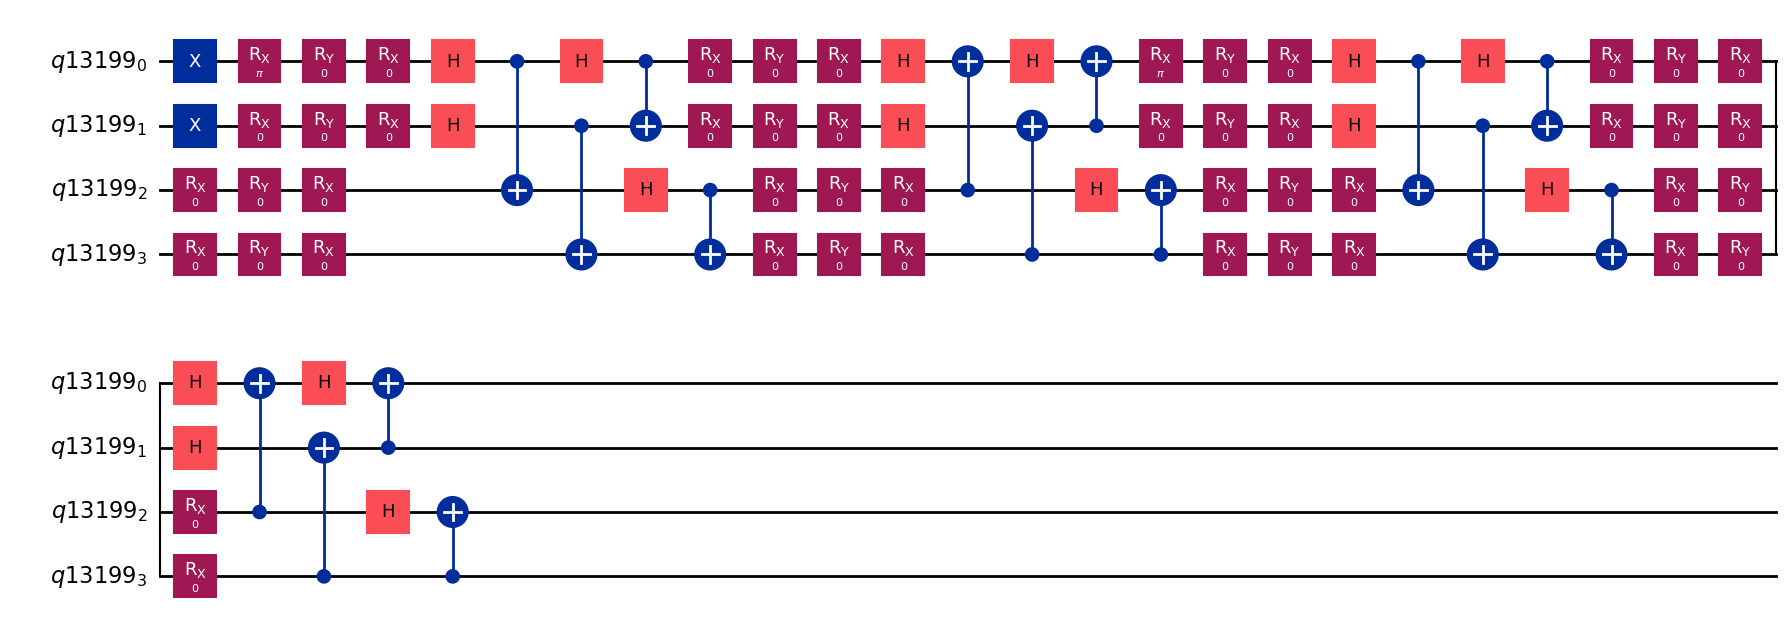

In [91]:
nodes_number = 3
# Anzatz assume only unentagled states.
# Since we are trying to get the domain wall we fix the first and last spin states to opposite direcions
def anzatz_qc(theta, nodes_number, el_num):
    q_r = Q_R(nodes_number * 2)
    v_qc = QuantumCircuit(q_r)
    for i in range(el_num):
        v_qc.x(i)
    i_theta = 0
    for i in range(0, nodes_number * 2):
        v_qc.rx(theta[i_theta],i)
        i_theta = i_theta + 1
        v_qc.ry(theta[i_theta],i)
        i_theta = i_theta + 1
        v_qc.rx(theta[i_theta],i)
        i_theta = i_theta + 1
    #v_qc.x(bit_size-1)
        #v_qc.x(bit_size-1)
    for i in range(0, nodes_number):
        v_qc.h(i)
        v_qc.cx(i, i + nodes_number)
    for i in range(0, nodes_number-1):
        v_qc.h(i)
        v_qc.cx(i, i + 1)
    for i in range(nodes_number, 2 * nodes_number-1):
        v_qc.h(i)
        v_qc.cx(i, i + 1)
        
    #v_qc.h(nodes_number * 2 - 1)
    #v_qc.cx(nodes_number * 2 - 1, 0)
            
    #v_qc.cz(bit_size - 1, 0)
    for i in range(0, nodes_number * 2):
        v_qc.rx(theta[i_theta],i)
        i_theta = i_theta + 1
        v_qc.ry(theta[i_theta],i)
        i_theta = i_theta + 1
        v_qc.rx(theta[i_theta],i)
        i_theta = i_theta + 1
    
    for i in range(0, nodes_number):
        v_qc.h(i)
        v_qc.cx(i + nodes_number, i)
    for i in range(0, nodes_number - 1):
        v_qc.h(i)
        v_qc.cx(i + 1, i)
    for i in range(nodes_number, 2 * nodes_number - 1):
        v_qc.h(i)
        v_qc.cx(i + 1, i)

    for i in range(0, nodes_number * 2):
        v_qc.rx(theta[i_theta],i)
        i_theta = i_theta + 1
        v_qc.ry(theta[i_theta],i)
        i_theta = i_theta + 1
        v_qc.rx(theta[i_theta],i)
        i_theta = i_theta + 1
    #v_qc.x(bit_size-1)
        #v_qc.x(bit_size-1)
    for i in range(0, nodes_number):
        v_qc.h(i)
        v_qc.cx(i, i + nodes_number)
    for i in range(0, nodes_number-1):
        v_qc.h(i)
        v_qc.cx(i, i + 1)
    for i in range(nodes_number, 2 * nodes_number-1):
        v_qc.h(i)
        v_qc.cx(i, i + 1)
        
    #v_qc.h(nodes_number * 2 - 1)
    #v_qc.cx(nodes_number * 2 - 1, 0)
            
    #v_qc.cz(bit_size - 1, 0)
    for i in range(0, nodes_number * 2):
        v_qc.rx(theta[i_theta],i)
        i_theta = i_theta + 1
        v_qc.ry(theta[i_theta],i)
        i_theta = i_theta + 1
        v_qc.rx(theta[i_theta],i)
        i_theta = i_theta + 1
    
    for i in range(0, nodes_number):
        v_qc.h(i)
        v_qc.cx(i + nodes_number, i)
    for i in range(0, nodes_number - 1):
        v_qc.h(i)
        v_qc.cx(i + 1, i)
    for i in range(nodes_number, 2 * nodes_number - 1):
        v_qc.h(i)
        v_qc.cx(i + 1, i)
        
    #v_qc.h(nodes_number * 2 - 1)
    #v_qc.cx(nodes_number * 2 - 1, 0)
    
    return v_qc

theta = [math.pi, 0 , 0,     0, 0, 0,      0, 0, 0,      0, 0, 0,         0, 0 , 0,     0, 0, 0,      0, 0, 0,      0, 0, 0, math.pi, 0 , 0,     0, 0, 0,      0, 0, 0,      0, 0, 0,         0, 0 , 0,     0, 0, 0,      0, 0, 0,      0, 0, 0]
qc = anzatz_qc(theta, 2,2)
qc.draw('mpl')

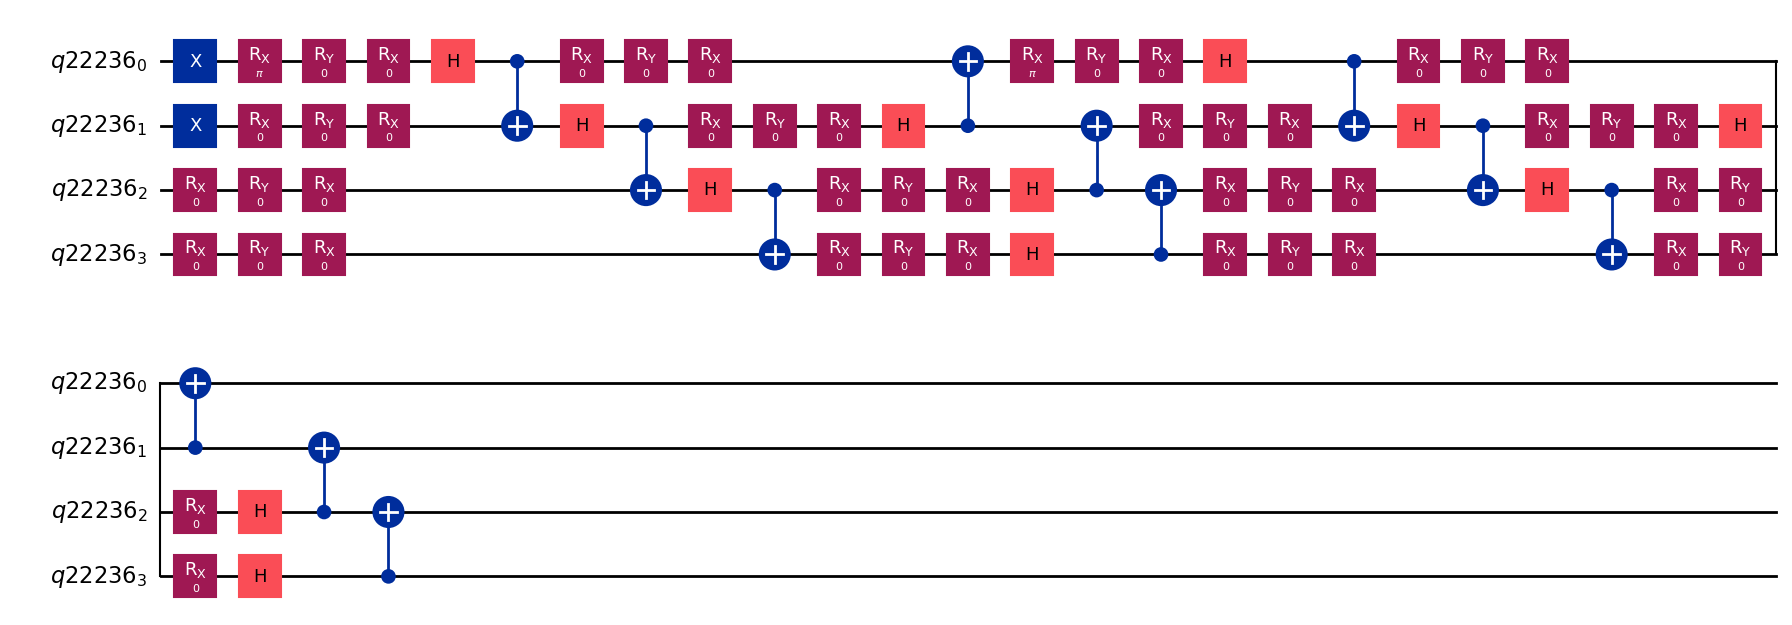

In [126]:
nodes_number = 3
# Anzatz assume only unentagled states.
# Since we are trying to get the domain wall we fix the first and last spin states to opposite direcions
def anzatz_qc(theta, nodes_number, el_num):
    q_r = Q_R(nodes_number * 2)
    v_qc = QuantumCircuit(q_r)
    for i in range(el_num):
        v_qc.x(i)
    i_theta = 0
    for i in range(0, nodes_number * 2):
        v_qc.rx(theta[i_theta],i)
        i_theta = i_theta + 1
        v_qc.ry(theta[i_theta],i)
        i_theta = i_theta + 1
        v_qc.rx(theta[i_theta],i)
        i_theta = i_theta + 1
    #v_qc.x(bit_size-1)
        #v_qc.x(bit_size-1)
    for i in range(0, nodes_number * 2 - 1):
        v_qc.h(i)
        v_qc.cx(i, i + 1)
   
        
    #v_qc.h(nodes_number * 2 - 1)
    #v_qc.cx(nodes_number * 2 - 1, 0)
            
    #v_qc.cz(bit_size - 1, 0)
    for i in range(0, nodes_number * 2):
        v_qc.rx(theta[i_theta],i)
        i_theta = i_theta + 1
        v_qc.ry(theta[i_theta],i)
        i_theta = i_theta + 1
        v_qc.rx(theta[i_theta],i)
        i_theta = i_theta + 1
    
    for i in range(0, nodes_number * 2 - 1):
        v_qc.h(i+1)
        v_qc.cx(i + 1, i)
   
    for i in range(0, nodes_number * 2):
        v_qc.rx(theta[i_theta],i)
        i_theta = i_theta + 1
        v_qc.ry(theta[i_theta],i)
        i_theta = i_theta + 1
        v_qc.rx(theta[i_theta],i)
        i_theta = i_theta + 1
    #v_qc.x(bit_size-1)
        #v_qc.x(bit_size-1)
    for i in range(0, nodes_number * 2 - 1):
        v_qc.h(i)
        v_qc.cx(i, i + 1)
   
        
    #v_qc.h(nodes_number * 2 - 1)
    #v_qc.cx(nodes_number * 2 - 1, 0)
            
    #v_qc.cz(bit_size - 1, 0)
    for i in range(0, nodes_number * 2):
        v_qc.rx(theta[i_theta],i)
        i_theta = i_theta + 1
        v_qc.ry(theta[i_theta],i)
        i_theta = i_theta + 1
        v_qc.rx(theta[i_theta],i)
        i_theta = i_theta + 1
    
    for i in range(0, nodes_number * 2 - 1):
        v_qc.h(i+1)
        v_qc.cx(i + 1, i)   
    #v_qc.h(nodes_number * 2 - 1)
    #v_qc.cx(nodes_number * 2 - 1, 0)
    
    return v_qc

theta = [math.pi, 0 , 0,     0, 0, 0,      0, 0, 0,      0, 0, 0,         0, 0 , 0,     0, 0, 0,      0, 0, 0,      0, 0, 0, math.pi, 0 , 0,     0, 0, 0,      0, 0, 0,      0, 0, 0,         0, 0 , 0,     0, 0, 0,      0, 0, 0,      0, 0, 0]
qc = anzatz_qc(theta, 2,2)
qc.draw('mpl')

In [127]:
# defining a cost function
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}
def estim(theta, nodes_number, hamiltonian, el_num):
    v_qc = anzatz_qc(theta, nodes_number, el_num)
    
    estimator = StatevectorEstimator()
    job = estimator.run([(v_qc, hamiltonian)])
    estimator_expvals = job.result()[0].data.evs
    
      
    #print 
    #print('Energy: ' + str(estimator_expvals))
    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = theta
    cost_history_dict["cost_history"].append(estimator_expvals)
    return estimator_expvals
#J = 1
#t = 1
#n_p = 1
#e_f = 10
#hamiltonian = full_ham(2, mag, J, t, n_p, e_f, periodic = True)
#theta = [math.pi, 0 , 0,     0, 0, 0,      0, 0, 0,      0, 0, 0,           0, 0 , 0,     0, 0, 0,      0, 0, 0,      0, 0, 0]
#print(hamiltonian)
#estim(theta, 2, hamiltonian)

In [132]:
# Hamiltonian parameters
nodes_number = 3 #number of nodes
J = 50 #s-d exchange constant
t = 0.2 #hopping matrix element (kinetic energy coefficient)
particle_number = 3
Fermi_level = 200

#Cost history initialization
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

import random
num = random.random()
#print(num)

#initialize the state
x0 = []
for i in range((nodes_number * 2) * 12):
    x0.append(random.random())

start = time.time()
#define the Hamiltonian
hamiltonian = full_ham(nodes_number, mag, J, t, particle_number, Fermi_level, periodic = False)
#print(hamiltonian)
#Optimization
res = minimize(
        estim,
        x0,
        args=(nodes_number , hamiltonian, particle_number),
        method="cobyla",
        options={"maxiter":  3000}
    )
end = time.time()
print(['time elapsed: ' + str(end - start) + ' sec'])

['time elapsed: 120.01122856140137 sec']


In [119]:
print(res)
print(cost_history_dict)

 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: -9.940494197595171
       x: [ 2.715e-01 -1.158e-02 ... -6.428e-01  5.504e-01]
    nfev: 2000
   maxcv: 0.0
{'prev_vector': array([ 2.70782251e-01, -1.22001364e-02,  4.84633631e-01,  1.42749452e+00,
        2.47692715e-01, -2.97212603e-01,  2.74406973e-01, -4.69121305e-02,
       -1.00880235e-01,  2.34728365e-01,  1.48232528e+00,  4.85178494e-01,
        7.69518255e-01,  2.08680532e+00,  8.99163891e-01, -3.52505646e-01,
        8.89937407e-01,  7.59354925e-02,  2.00000394e-01,  1.24906080e+00,
        8.06660395e-01,  4.98010747e-01,  8.02667009e-01,  1.34149124e+00,
        6.39421116e-02, -6.10496818e-02, -2.53418269e-01,  1.57037300e+00,
        1.80208096e+00,  1.57121797e+00,  2.43987342e-01,  1.76792417e-01,
       -2.51377389e-01, -6.13944465e-02,  4.40898018e-01,  8.94160197e-01,
        4.59776706e-01,  9.78729414e-01,  1.12468854e+00, -2.74827705e-01,
        1.76640855e-

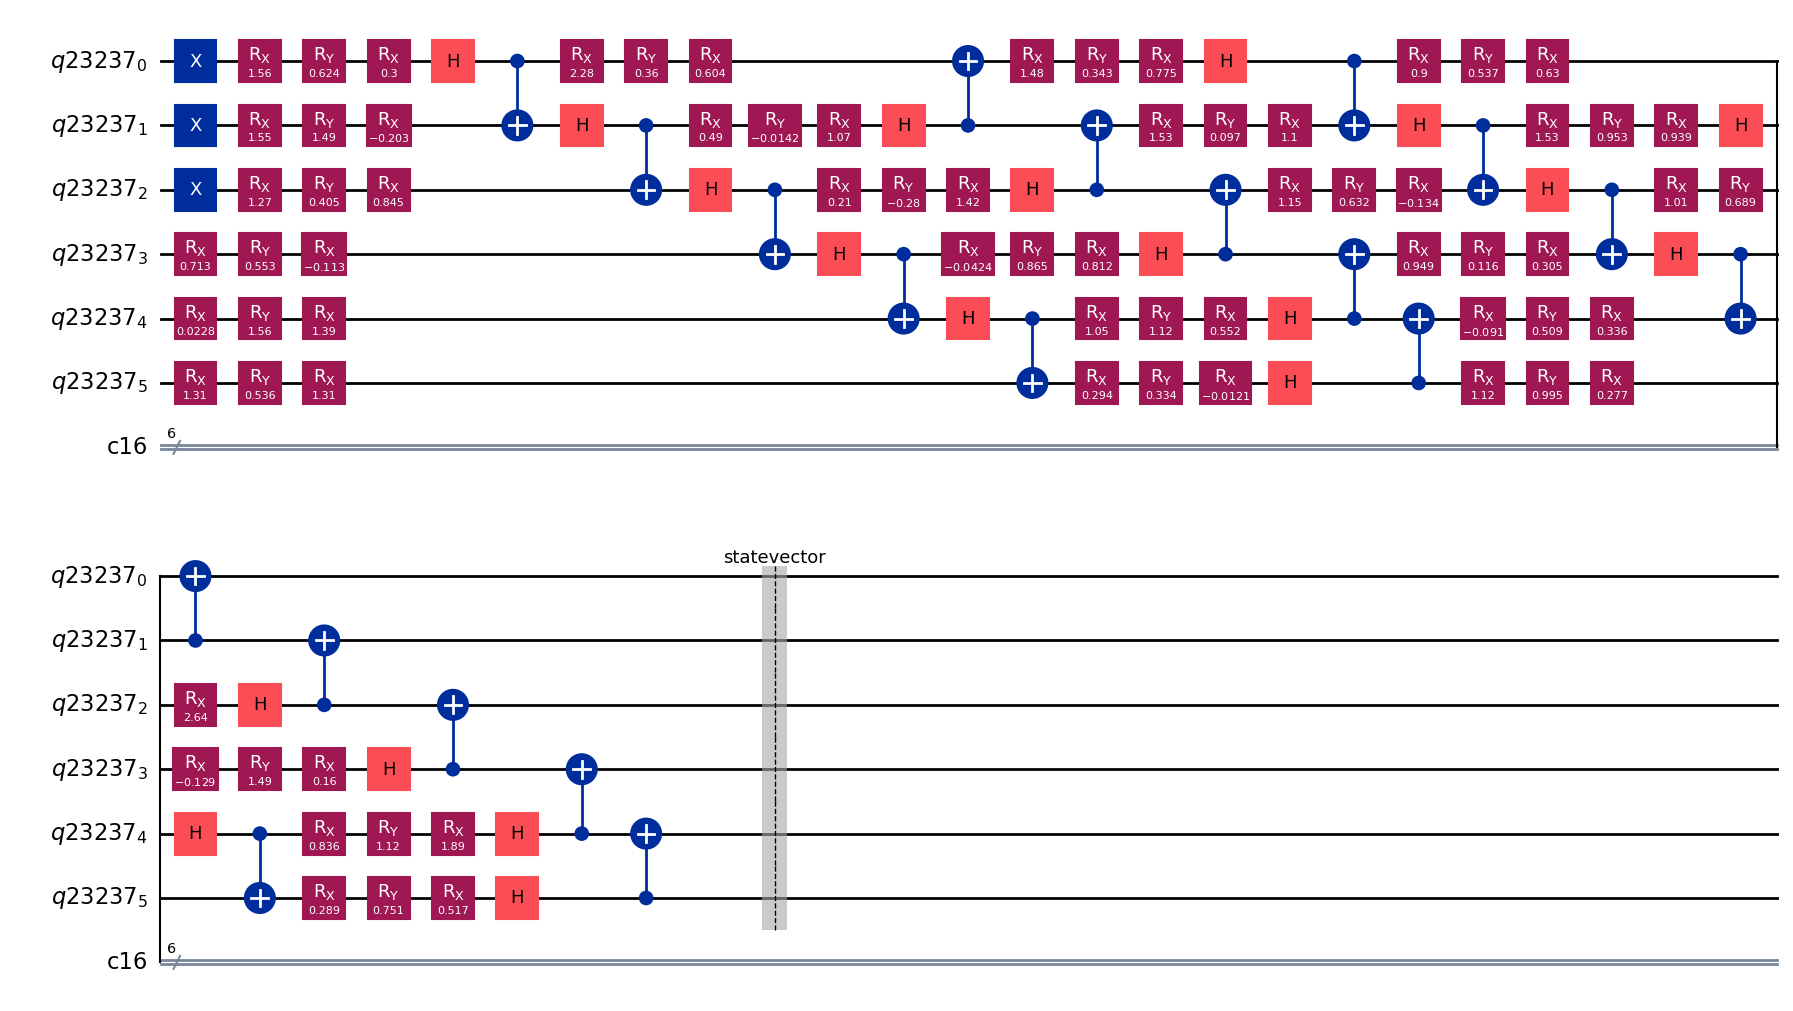

In [129]:
q_r = Q_R(nodes_number * 2)
cl_r = C_R(nodes_number * 2)
qc_f = QuantumCircuit(q_r,cl_r)
qc_1 = anzatz_qc(res.x, nodes_number, particle_number)
qc_f.append(qc_1, q_r)

#for i in range(bit_size):
#    qc_f.measure(i,i)
SimulatorAer = AerSimulator()

qc_f.save_statevector()

qc_f.decompose().draw('mpl')

In [130]:
from qiskit.quantum_info import partial_trace, DensityMatrix
from qiskit.visualization import plot_state_city

circ = transpile(qc_f, backend = SimulatorAer)
result = SimulatorAer.run(circ,shots = 1).result()
ground_state = result.get_statevector(circ)

#print(ground_state)

#ground_state.draw(output = 'latex')

#plot_state_city(dm)

In [131]:
import sys
sys.path.insert(0, 'C:/Users/Oleg/Google Диск/QC/Codes/QC-qiskit-codes/Library')
sys.path.insert(0, 'D:\Gdrive\Gdrive\Мой диск\QC\Codes\QC-qiskit-codes/Library')
import aux_func as af
n_nonzero = 0
n_states = pow(2, 2 * nodes_number)
states = []
prob = []
for i in range(n_states):
    pr = pow(abs(ground_state[i]), 2)
    if pr>1/n_states:
        n_nonzero = n_nonzero + 1
        states.append(i)
        prob.append(pr)
        print('state: ' + str(af.int_2_bin_word(i, 2 * nodes_number)) + ', prob: ' + str(pr) + ', complex amplitude: ' + str(ground_state[i]))
    
print('Energy: ' + str(res.fun))

state: 011001, prob: 0.5973483035289896, complex amplitude: (-0.29482008970226425-0.7144434324961904j)
state: 011100, prob: 0.04076044599540474, complex amplitude: (-0.01632414058856047-0.20123113185948552j)
state: 101001, prob: 0.17388175826667307, complex amplitude: (0.3948530335687063-0.13406282164814806j)
state: 110001, prob: 0.13604635320392885, complex amplitude: (-0.14146950689559828+0.34063577589948646j)
Energy: -45.810879712977666


<>:3: SyntaxWarning: invalid escape sequence '\G'
<>:3: SyntaxWarning: invalid escape sequence '\G'
C:\Users\Zver\AppData\Local\Temp\ipykernel_10292\3226938467.py:3: SyntaxWarning: invalid escape sequence '\G'
  sys.path.insert(0, 'D:\Gdrive\Gdrive\Мой диск\QC\Codes\QC-qiskit-codes/Library')


In [98]:
def simul(nodes_number, particle_number, Fermi_level, J, t, mag, periodic = True):


    #Optimization
    cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
    }

    import random
    num = random.random()
    #print(num)
    
    #initialize the state
    x0 = []
    for i in range((nodes_number * 2) * 6):
        x0.append(random.random())
    
    #define the Hamiltonian
    hamiltonian = full_ham(nodes_number, mag, J, t, particle_number, Fermi_level, periodic = False)
    #print(hamiltonian)
    #Optimization
    res = minimize(
            estim,
            x0,
            args=(nodes_number , hamiltonian),
            method="cobyla",
        )
    #Analysis
    q_r = Q_R(nodes_number * 2)
    cl_r = C_R(nodes_number * 2)
    qc_f = QuantumCircuit(q_r,cl_r)
    qc_1 = anzatz_qc(res.x, nodes_number)
    qc_f.append(qc_1, q_r)
    SimulatorAer = AerSimulator()
    qc_f.save_statevector()
    circ = transpile(qc_f, backend = SimulatorAer)
    result = SimulatorAer.run(circ,shots = 1).result()
    ground_state = result.get_statevector(circ)
    n_nonzero = 0
    n_states = pow(2, 2 * nodes_number)
    states = []
    prob = []
    full_state = []
    state_bin = []
    for i in range(n_states):
        pr = pow(abs(ground_state[i]), 2)
        if pr>1/n_states:
            n_nonzero = n_nonzero + 1
            states.append(i)
            prob.append(pr)
            full_state.append(ground_state[i])
            state_bin.append(af.int_2_bin_word(i, 2 * nodes_number))
            #print('state: ' + str(af.int_2_bin_word(i, 2 * nodes_number)) + ', prob: ' + str(pr) + ', complex amplitude: ' + str(ground_state[i]))
    energy_fin = res.fun
    return states, prob, full_state, state_bin, energy_fin

In [132]:
nodes_number = 2
particle_number = 1
Fermi_level = 10
J = 0.1
t = 1
mag = uniform_z(nodes_number)
periodic = False
[states, prob, full_state, state_bin, energy_fin] = simul(nodes_number, particle_number, Fermi_level, J, t, mag, periodic)
#print('state: ' + str(af.int_2_bin_word(i, 2 * nodes_number)) + ', prob: ' + str(pr) + ', complex amplitude: ' + str(ground_state[i])) for i in range(len(prob))

In [133]:
print('Energy: ' + str(energy_fin))
print('Full state consists of:')
for i in range(len(prob)):
    print('state '+ str(i) + ': ' + str(af.int_2_bin_word(i, 2 * nodes_number)) + ', prob: ' + str(prob[i]) + ', complex amplitude: ' + str(full_state[i])) 

Energy: -1.0999362933136965
Full state consists of:
state 0: 0000, prob: 0.49772318556166106, complex amplitude: (0.029901893190298567+0.7048610234261057j)
state 1: 0001, prob: 0.5022740070769761, complex amplitude: (0.028961349883596436+0.7081209270244003j)


In [134]:
nodes_number = 3
particle_number = 3
Fermi_level = 10
J = 4
t = 1
mag = uniform_z(nodes_number)
periodic = False
for try_number in range(5):
    [states, prob, full_state, state_bin, energy_fin] = simul(nodes_number, particle_number, Fermi_level, J, t, mag, periodic)
    print('Try ' + str(try_number))
    print('Energy: ' + str(energy_fin))
    print('Full state consists of:')
    for i in range(len(prob)):
        print('state '+ str(i) + ': ' + str(state_bin[i]) + ', prob: ' + str(prob[i]) + ', complex amplitude: ' + str(full_state[i])) 

Try 0
Energy: -8.002220533219287
Full state consists of:
state 0: 101001, prob: 0.49992499234948323, complex amplitude: (0.37687699327348617+0.5982380164204043j)
state 1: 111000, prob: 0.4999277030832395, complex amplitude: (0.37687778035179736+0.598239786173021j)
Try 1
Energy: -4.084799163545417
Full state consists of:
state 0: 100011, prob: 0.24762976623193192, complex amplitude: (0.33663078559972825+0.36648257860155065j)
state 1: 101010, prob: 0.21478689229464937, complex amplitude: (-0.28099305271206076-0.36855094169219865j)
state 2: 110001, prob: 0.21642213167178392, complex amplitude: (-0.2800592970490364-0.3714686013759218j)
state 3: 111000, prob: 0.2726077363537167, complex amplitude: (0.35428627251798445+0.38352180310776224j)
Try 2
Energy: -11.999996767177667
Full state consists of:
state 0: 111000, prob: 0.9999998073579921, complex amplitude: (-0.8037234946059943+0.5950028164440234j)
Try 3
Energy: -11.991471477384813
Full state consists of:
state 0: 111000, prob: 0.9991048902